In [1]:
import gymnasium as gym
from bettermdptools.envs.cartpole_wrapper import CartpoleWrapper
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.decorators import add_to
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Value Iteration

In [ ]:
# Define base CartPole environment
base_env = gym.make('CartPole-v1', render_mode=None)
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
# Override default parameters in CartpoleWrapper when instantiated
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)

# Grid Search Parameters
gammas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
n_iters = [10, 20, 50, 100, 200, 500, 1000]
theta = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# Perform Grid Search for VI
rewards_and_params_results_vi, highest_avg_reward_vi, best_params_vi = GridSearch.vi_grid_search(
    cartpole, gammas, n_iters, theta, verbose=False
)

# Print Results
print(f"Highest Average Reward: {highest_avg_reward_vi}")
print(f"Best Parameters (gamma, n_iters, theta): {best_params_vi}")

# RANDOM_SEED = 10
# Highest Average Reward: 9.64
# Best Parameters (gamma, n_iters, theta): (0.9, 10, 0.0001)

In [ ]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(rewards_and_params_results_vi)

# Split the 'params' tuple into separate columns
df[['gamma', 'n_iter', 'theta']] = pd.DataFrame(df['params'].tolist(), index=df.index)

# Drop the original 'params' column
df = df.drop(columns=['params'])

# Sort the DataFrame by 'avg_reward' from highest to lowest
df = df.sort_values(by='avg_reward', ascending=False)

print(df)

     avg_reward  gamma  n_iter    theta
143        9.64   0.90      10  0.00010
6          9.57   0.10      20  0.01000
266        9.57   0.93     200  0.01000
309        9.56   0.94     500  0.00001
238        9.55   0.92     500  0.00010
..          ...    ...     ...      ...
474        9.17   0.99     100  0.00001
236        9.16   0.92     500  0.01000
198        9.15   0.91     200  0.00010
304        9.15   0.94     200  0.00001
469        9.09   0.99      50  0.00001

[490 rows x 4 columns]


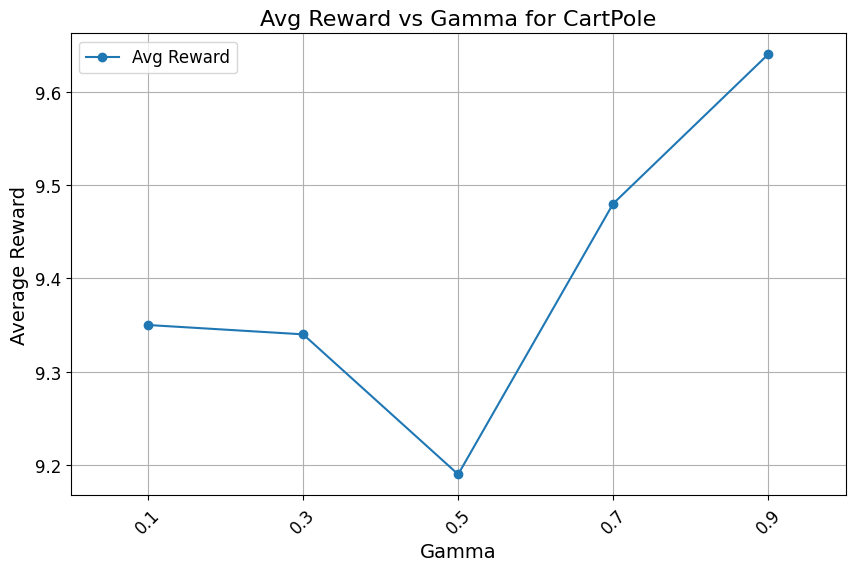

In [13]:
# Filter rows where n_iter is 20, theta is 0.1, and gamma is in the specified list
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]
filtered_df = df[(df['n_iter'] == 10) & (df['theta'] == 0.0001) & (df['gamma'].isin(gammas))]

# Sort filtered_df by gamma
filtered_df = filtered_df.sort_values(by='gamma')

# Plot avg_reward vs gamma
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['gamma'], filtered_df['avg_reward'], marker='o', linestyle='-', label='Avg Reward')

# Set x-axis ticks and scale
plt.xticks(gammas, rotation=45, fontsize=12)  # Increased tick font size
plt.yticks(fontsize=12)  # Increased y-axis tick font size
plt.xlim(0.0, 1.0)

# Set axis labels with larger font size
plt.xlabel('Gamma', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)

# Set title and grid
plt.title('Avg Reward vs Gamma for CartPole', fontsize=16)
plt.grid()
plt.legend(fontsize=12)  # Increased legend font size
plt.show()

c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\bettermdptools\algorithms\planner.py:75: UserWarning: Max iterations reached before convergence.  Check n_iters.
  warnings.warn("Max iterations reached before convergence.  Check n_iters.")


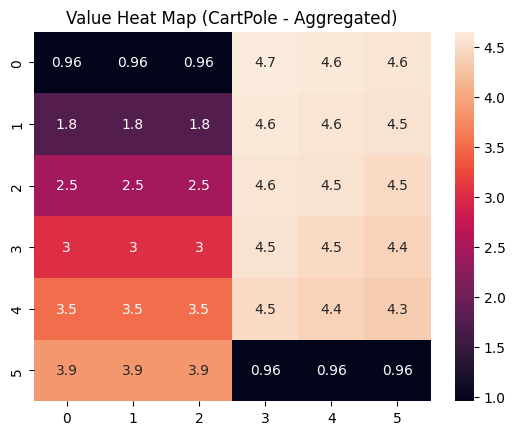

In [2]:
# Set random seed
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Initialize the CartPole environment with a wrapper
base_env = gym.make('CartPole-v1', render_mode=None)
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)
cartpole.action_space.seed(RANDOM_SEED)

# Value iteration parameters
gamma = 0.9
n_iter = 10
theta = 0.0001

# Run value iteration using the Planner class
V, V_track, pi = Planner(cartpole._P).value_iteration(gamma=gamma, n_iters=n_iter, theta=theta)

# Determine the size dynamically based on the length of V
# Adjust the heat map size based on CartPole's state space
size = (6, 6, 4, 23)  # (Position bins, Velocity bins, Angular velocity bins, Angle bins)

# # Reshape V into a 2D array for visualization
# # Combine 'position' and 'velocity' into one axis for simplicity
# reshaped_size = (6 * 6, 4 * 23)
# V_reshaped = np.around(V.reshape(reshaped_size), 2)
# # Create a heatmap from the reshaped data
# Plots.values_heat_map(data=V_reshaped, title="Value Heat Map (CartPole)", size=reshaped_size)

# Aggregate V over angular velocity and angle dimensions
V_aggregated = np.mean(V.reshape(6, 6, 4, 23), axis=(2, 3))
# Create a heatmap for position and velocity
Plots.values_heat_map(data=V_aggregated, title="Value Heat Map (CartPole - Aggregated)", size=(6, 6))


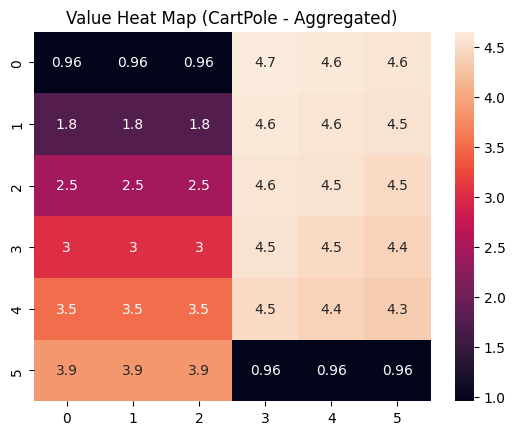

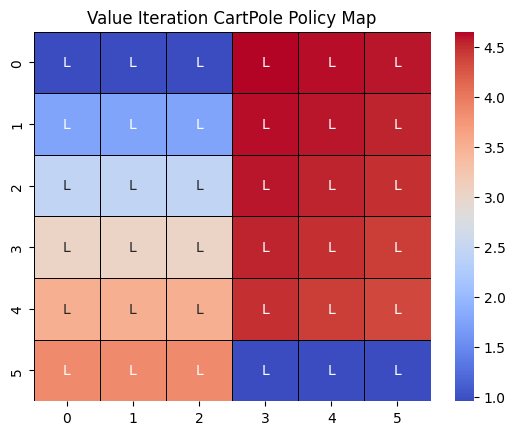

In [5]:
# Create actions dictionary for CartPole
cartpole_actions = {0: "L", 1: "R"}  # Left (L) and Right (R) actions

# Aggregate the value function over angular velocity and angle bins
V_aggregated = np.mean(V.reshape(6, 6, 4, 23), axis=(2, 3))

# Convert the policy dictionary to an array
policy_array = np.array([pi[s] for s in range(len(pi))])  # Convert policy dictionary to array

# Aggregate the policy over angular velocity and angle bins
policy_aggregated = policy_array.reshape(6, 6, 4, 23).mean(axis=(2, 3)).astype(int)

# Map the policy actions to readable labels ("L" for Left, "R" for Right)
policy_map = np.vectorize(cartpole_actions.get)(policy_aggregated)

# Define the heatmap plotting function
@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

# Title for the policy map
title = "Value Iteration CartPole Policy Map"

# Create the heatmap for the value function
Plots.values_heat_map(data=V_aggregated, title="Value Heat Map (CartPole - Aggregated)", size=(6, 6))

# Create the heatmap for the policy map
Plots.modified_plot_policy(val_max=V_aggregated, directions=policy_map, map_size=(6, 6), title=title)


c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\bettermdptools\algorithms\planner.py:75: UserWarning: Max iterations reached before convergence.  Check n_iters.
  warnings.warn("Max iterations reached before convergence.  Check n_iters.")


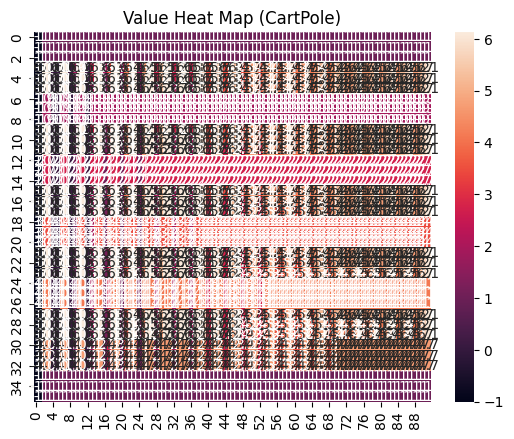

In [6]:
# Set random seed
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Initialize the CartPole environment with a wrapper
base_env = gym.make('CartPole-v1', render_mode=None)
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)
cartpole.action_space.seed(RANDOM_SEED)

# Value iteration parameters
gamma = 0.9
n_iter = 10
theta = 0.0001

# Run value iteration using the Planner class
V, V_track, pi = Planner(cartpole._P).value_iteration(gamma=gamma, n_iters=n_iter, theta=theta)

# Determine the size dynamically based on the length of V
# Adjust the heat map size based on CartPole's state space
size = (6, 6, 4, 23)  # (Position bins, Velocity bins, Angular velocity bins, Angle bins)

# Reshape V into a 2D array for visualization
# Combine 'position' and 'velocity' into one axis for simplicity
reshaped_size = (6 * 6, 4 * 23)
V_reshaped = np.around(V.reshape(reshaped_size), 2)
# Create a heatmap from the reshaped data
Plots.values_heat_map(data=V_reshaped, title="Value Heat Map (CartPole)", size=reshaped_size)

# # Aggregate V over angular velocity and angle dimensions
# V_aggregated = np.mean(V.reshape(6, 6, 4, 23), axis=(2, 3))
# # Create a heatmap for position and velocity
# Plots.values_heat_map(data=V_aggregated, title="Value Heat Map (CartPole - Aggregated)", size=(6, 6))

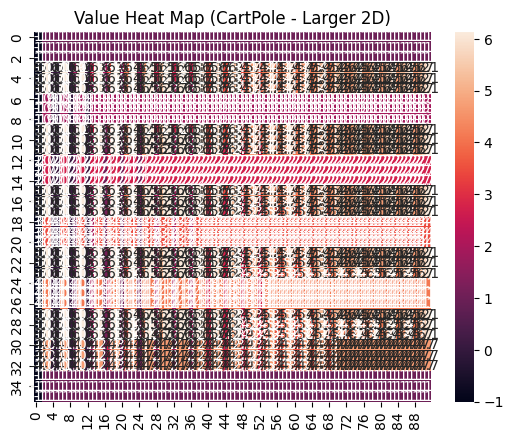

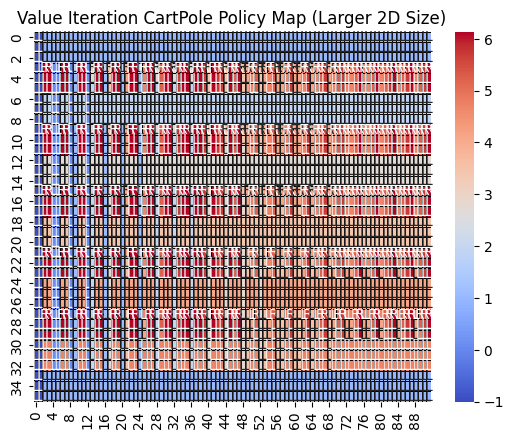

In [7]:
# Create actions dictionary for CartPole
cartpole_actions = {0: "L", 1: "R"}  # Left (L) and Right (R) actions

# Reshape the value function into a larger 2D array for visualization
reshaped_size = (6 * 6, 4 * 23)  # Combine position × velocity into one axis and angular velocity × angle into the other
V_reshaped = np.around(V.reshape(reshaped_size), 2)

# Reshape the policy into a larger 2D array
policy_array = np.array([pi[s] for s in range(len(pi))])  # Convert policy dictionary to array
policy_reshaped = policy_array.reshape(reshaped_size)

# Map the policy actions to readable labels ("L" for Left, "R" for Right)
policy_map = np.vectorize(cartpole_actions.get)(policy_reshaped)

# Define the heatmap plotting function
@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.5,
        linecolor="black",
    ).set(title=title)
    plt.show()

# Title for the policy map
title = "Value Iteration CartPole Policy Map (Larger 2D Size)"

# Create the heatmap for the value function
Plots.values_heat_map(data=V_reshaped, title="Value Heat Map (CartPole - Larger 2D)", size=reshaped_size)

# Create the heatmap for the policy map
Plots.modified_plot_policy(val_max=V_reshaped, directions=policy_map, map_size=reshaped_size, title=title)

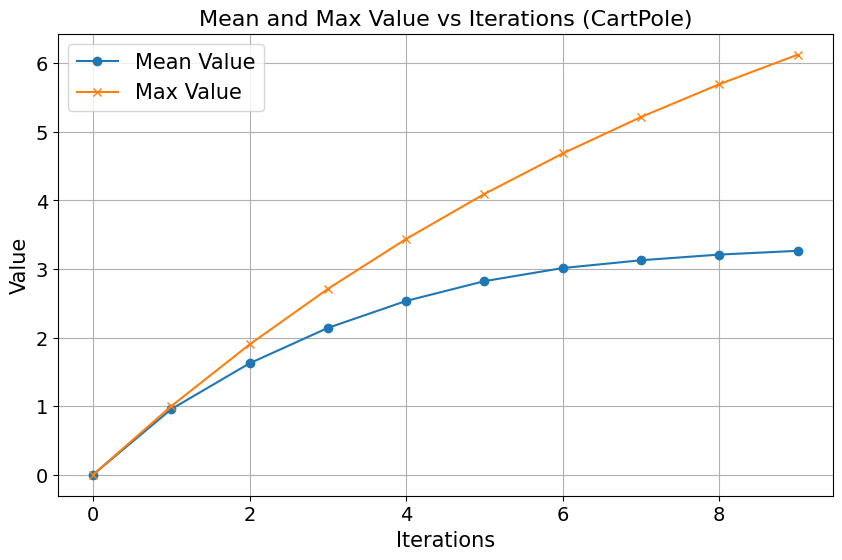

In [36]:
# Assume V_track is a numpy array of shape (n_iters, n_states)
# Replace this with your actual V_track data
# Each row contains the value function at a specific iteration

# Clip trailing zeros if convergence is reached before max iterations
mean_values_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
max_values_per_iter = np.trim_zeros(np.max(V_track, axis=1), 'b')

# Plot mean and max values over iterations
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter, label="Mean Value", linestyle='-', marker='o')
plt.plot(max_values_per_iter, label="Max Value", linestyle='-', marker='x')

# Customize tick parameters for the x and y axes
plt.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis numbers
plt.tick_params(axis='y', labelsize=14)  # Increase font size for y-axis numbers

# Add labels, legend, and title
plt.xlabel("Iterations", fontsize=15)  # Increase font size for x-axis label
plt.ylabel("Value", fontsize=15)  # Increase font size for y-axis label
plt.title("Mean and Max Value vs Iterations (CartPole)", fontsize=16)  # Increase font size for the title
plt.legend(fontsize=15)  # Increase font size for the legend
plt.grid()

# Show plot
plt.show()


In [ ]:
# Test value iteration on CartPole
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED) 
cartpole.action_space.seed(RANDOM_SEED)
cartpole.reset(seed=RANDOM_SEED)
# Run tests
test_scores = TestEnv.test_env(env=cartpole, n_iters=1000, render=False, pi=pi, user_input=False)
# Print results
# print(test_scores)
print(f"Average Test Score: {np.mean(test_scores)}")

Average Test Score: 9.367


# Policy Iteration

In [21]:
RANDOM_SEED = 10

# Grid search parameters
gammas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
n_iters = [20]
theta = [0.01, 0.001, 0.0001]

# Create base CartPole environment
base_env = gym.make('CartPole-v1', render_mode=None)

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)

# Wrap the CartPole environment with custom parameters
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)

# Perform grid search for policy iteration
rewards_and_params_results_pi, highest_avg_reward_pi, best_params_pi = GridSearch.pi_grid_search(
    cartpole, gammas, n_iters, theta, verbose=False
)

# Print results
print(f"Highest Average Reward: {highest_avg_reward_pi}")
print(f"Best Parameters (gamma, n_iters, theta): {best_params_pi}")

# RANDOM_SEED = 10
# Highest Average Reward: 9.5
# Best Parameters (gamma, n_iters, theta): (0.5, 20, 0.0001)

Highest Average Reward: 9.5
Best Parameters (gamma, n_iters, theta): (0.5, 20, 0.0001)


In [17]:
# Convert the dictionary to a pandas DataFrame
df_pi = pd.DataFrame(rewards_and_params_results_pi)

# Split the 'params' tuple into separate columns
df_pi[['gamma', 'n_iter', 'theta']] = pd.DataFrame(df_pi['params'].tolist(), index=df_pi.index)

# Drop the original 'params' column
df_pi = df_pi.drop(columns=['params'])

# Sort the DataFrame by 'avg_reward' from highest to lowest
df_pi = df_pi.sort_values(by='avg_reward', ascending=False)

print(df_pi)

    avg_reward  gamma  n_iter   theta
8         9.50   0.50     100  0.0001
14        9.43   0.90     100  0.0001
0         9.42   0.10     100  0.0100
7         9.41   0.50     100  0.0010
12        9.38   0.90     100  0.0100
5         9.38   0.30     100  0.0001
17        9.36   0.99     100  0.0001
6         9.36   0.50     100  0.0100
4         9.36   0.30     100  0.0010
1         9.34   0.10     100  0.0010
15        9.33   0.99     100  0.0100
2         9.31   0.10     100  0.0001
3         9.30   0.30     100  0.0100
16        9.30   0.99     100  0.0010
13        9.29   0.90     100  0.0010
9         9.29   0.70     100  0.0100
10        9.28   0.70     100  0.0010
11        9.28   0.70     100  0.0001


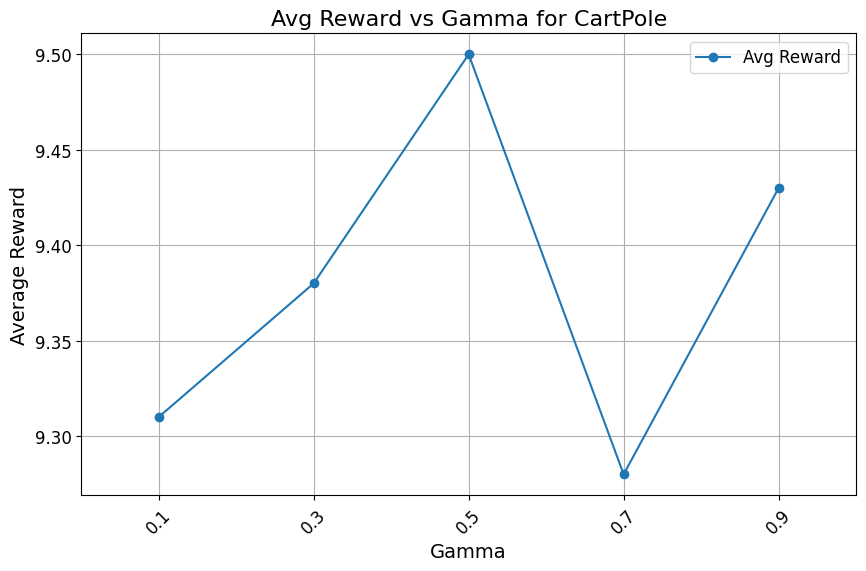

In [15]:
# Filter rows where n_iter is 20, theta is 0.1, and gamma is in the specified list
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]
filtered_df = df_pi[(df_pi['n_iter'] == 20) & (df_pi['theta'] == 0.0001) & (df_pi['gamma'].isin(gammas))]

# Sort filtered_df by gamma
filtered_df = filtered_df.sort_values(by='gamma')

# Plot avg_reward vs gamma
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['gamma'], filtered_df['avg_reward'], marker='o', linestyle='-', label='Avg Reward')

# Set x-axis ticks and scale
plt.xticks(gammas, rotation=45, fontsize=12)  # Increased tick font size
plt.yticks(fontsize=12)  # Increased y-axis tick font size
plt.xlim(0.0, 1.0)

# Set axis labels with larger font size
plt.xlabel('Gamma', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)

# Set title and grid
plt.title('Avg Reward vs Gamma for CartPole', fontsize=16)
plt.grid()
plt.legend(fontsize=12)  # Increased legend font size
plt.show()

In [23]:
# Set random seed
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Initialize the CartPole environment with a wrapper
base_env = gym.make('CartPole-v1', render_mode=None)
base_env.reset(seed=RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)

# Policy iteration parameters
gamma = 0.5
n_iter = 20
theta = 0.0001

# Run policy iteration using the Planner class
V_pi, V_track_pi, pi_pi = Planner(cartpole._P).policy_iteration(gamma=gamma, n_iters=n_iter, theta=theta)

# Determine the size dynamically based on the CartPole state space
# Adjust for discretized bins: (Position, Velocity, Angular Velocity, Angle)
size = (6, 6, 4, 23)  # Corresponding to the wrapper's parameters

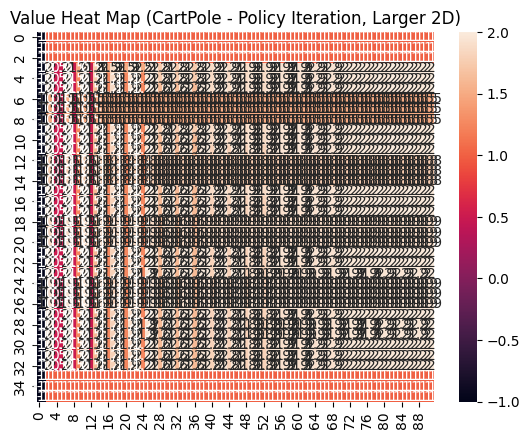

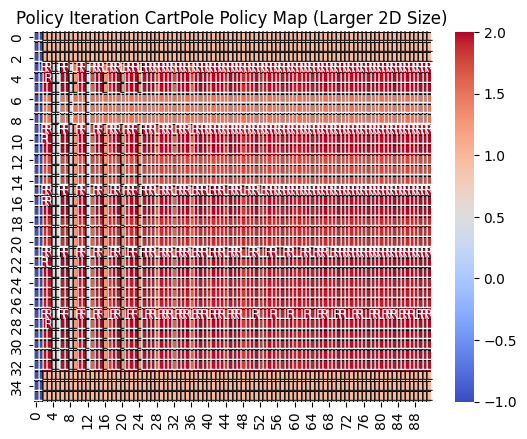

In [24]:
# Create actions dictionary for CartPole
cartpole_actions = {0: "L", 1: "R"}  # Left (L) and Right (R) actions

# Reshape the value function from policy iteration into a larger 2D array for visualization
reshaped_size = (6 * 6, 4 * 23)  # Combine position × velocity into one axis and angular velocity × angle into the other
V_pi_reshaped = np.around(V_pi.reshape(reshaped_size), 2)

# Reshape the policy from policy iteration into a larger 2D array
policy_array_pi = np.array([pi_pi[s] for s in range(len(pi_pi))])  # Convert policy dictionary to array
policy_reshaped_pi = policy_array_pi.reshape(reshaped_size)

# Map the policy actions to readable labels ("L" for Left, "R" for Right)
policy_map_pi = np.vectorize(cartpole_actions.get)(policy_reshaped_pi)

# Define the heatmap plotting function
@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.5,
        linecolor="black",
    ).set(title=title)
    plt.show()

# Title for the policy map
title_pi = "Policy Iteration CartPole Policy Map (Larger 2D Size)"

# Create the heatmap for the value function
Plots.values_heat_map(data=V_pi_reshaped, title="Value Heat Map (CartPole - Policy Iteration, Larger 2D)", size=reshaped_size)

# Create the heatmap for the policy map
Plots.modified_plot_policy(val_max=V_pi_reshaped, directions=policy_map_pi, map_size=reshaped_size, title=title_pi)

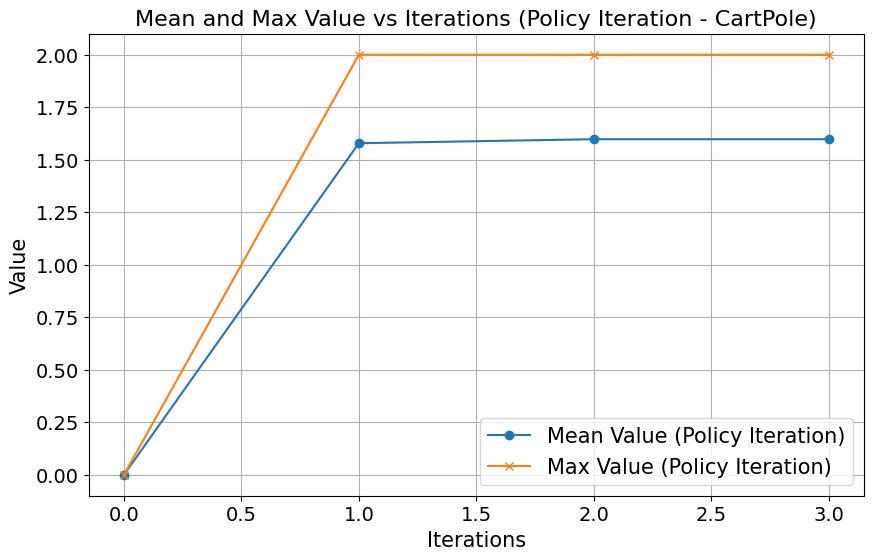

In [35]:
# Assume V_track_pi is a numpy array of shape (n_iters, n_states)
# Replace this with your actual V_track_pi data from policy iteration
# Each row contains the value function at a specific iteration

# Clip trailing zeros if convergence is reached before max iterations
mean_values_per_iter_pi = np.trim_zeros(np.mean(V_track_pi, axis=1), 'b')
max_values_per_iter_pi = np.trim_zeros(np.max(V_track_pi, axis=1), 'b')

# Plot mean and max values over iterations for policy iteration
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter_pi, label="Mean Value (Policy Iteration)", linestyle='-', marker='o')
plt.plot(max_values_per_iter_pi, label="Max Value (Policy Iteration)", linestyle='-', marker='x')

# Customize tick parameters for the x and y axes
plt.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis numbers
plt.tick_params(axis='y', labelsize=14)  # Increase font size for y-axis numbers

# Add labels, legend, and title
plt.xlabel("Iterations", fontsize=15)  # Add larger font for x-axis
plt.ylabel("Value", fontsize=15)  # Add larger font for y-axis
plt.title("Mean and Max Value vs Iterations (Policy Iteration - CartPole)", fontsize=16)  # Updated title
plt.legend(fontsize=15)  # Increased legend font size
plt.grid()

# Show plot
plt.show()


In [ ]:
# Test policy iteration on CartPole
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED) 
cartpole.action_space.seed(RANDOM_SEED)
cartpole.reset(seed=RANDOM_SEED)

# Run tests
test_scores_pi = TestEnv.test_env(env=cartpole, n_iters=1000, render=False, pi=pi_pi, user_input=False)

# Print results
print(f"Average Test Score (Policy Iteration, CartPole): {np.mean(test_scores_pi)}")

Average Test Score (Policy Iteration, CartPole): 9.367


# Q-Learning

In [ ]:
# Set random seed
RANDOM_SEED = 10

# Define parameters for Q-learning
gammas = [0.3, 0.5, 0.7, 0.9]
epsilon_decay = [0.3, 0.5, 0.7, 0.9]
n_iters = [10000]

# Initialize CartPole environment
base_env = gym.make('CartPole-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)

# Wrap the CartPole environment with custom parameters
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)

# Run Q-learning grid search
rewards_and_params_results_q, highest_avg_reward_q, best_params_q = GridSearch.q_learning_grid_search(
    env=cartpole,
    gamma=gammas,
    epsilon_decay=epsilon_decay,
    iters=n_iters,
    verbose=False
)

# Print the results
print("Highest Average Reward from Q-learning:", highest_avg_reward_q)
print("Best Parameters for Q-learning:", best_params_q)

# Highest Average Reward from Q-learning: 135.0
# Best Parameters for Q-learning: (0.5, 0.5, 10000)

 74%|███████▍  | 7389/10000 [03:35<00:55, 46.72it/s] c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\bettermdptools\algorithms\rl.py:183: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn("Episode was truncated.  TD target value may be incorrect.")


Highest Average Reward from Q-learning: 135.0
Best Parameters for Q-learning: (0.5, 0.5, 10000)


In [45]:
# Convert dictionary to DataFrame
df_q = pd.DataFrame(rewards_and_params_results_q)
df_q[['gamma', 'epsilon_decay', 'iters']] = pd.DataFrame(df_q['params'].tolist(), index=df_q.index)
df_q = df_q.drop(columns=['params'])

# Sort DataFrame in descending order by avg_reward
df_q = df_q.sort_values(by='avg_reward', ascending=False)

# Save DataFrame to a CSV file
file_path = "q-learning_cp_results.csv"
df_q.to_csv(file_path, index=False)

In [48]:
print(df_q)

    avg_reward  gamma  epsilon_decay  iters
5       135.00    0.5            0.5  10000
8       122.08    0.7            0.3  10000
12      120.17    0.9            0.3  10000
15      116.77    0.9            0.9  10000
7       112.45    0.5            0.9  10000
9       111.92    0.7            0.5  10000
10      111.91    0.7            0.7  10000
4       108.96    0.5            0.3  10000
14      108.76    0.9            0.7  10000
11      101.86    0.7            0.9  10000
1        91.11    0.3            0.5  10000
3        82.72    0.3            0.9  10000
6        79.47    0.5            0.7  10000
0        75.24    0.3            0.3  10000
13       73.57    0.9            0.5  10000
2        56.25    0.3            0.7  10000


In [49]:
# Set random seed
RANDOM_SEED = 10

# Initialize CartPole environment
base_env = gym.make('CartPole-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)

# Wrap the CartPole environment with custom parameters
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)

# Define parameters for Q-learning
gammas = 0.5
epsilon_decay = 0.5
n_iters = 10000

# Run Q-learning
Q, V_Q, pi_Q, Q_track, pi_track_Q = RL(cartpole).q_learning(
    gamma=gammas,
    epsilon_decay_ratio=epsilon_decay,
    n_episodes=n_iters
)

In [ ]:
# Test Q-learning on CartPole
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
cartpole.action_space.seed(RANDOM_SEED)
cartpole.reset(seed=RANDOM_SEED)

# Run tests
test_scores_q = TestEnv.test_env(env=cartpole, n_iters=1000, render=False, pi=pi_Q, user_input=False)

# Print results
print(f"Average Test Score (Q-learning, CartPole): {np.mean(test_scores_q)}")

Average Test Score (Q-learning, CartPole): 119.034


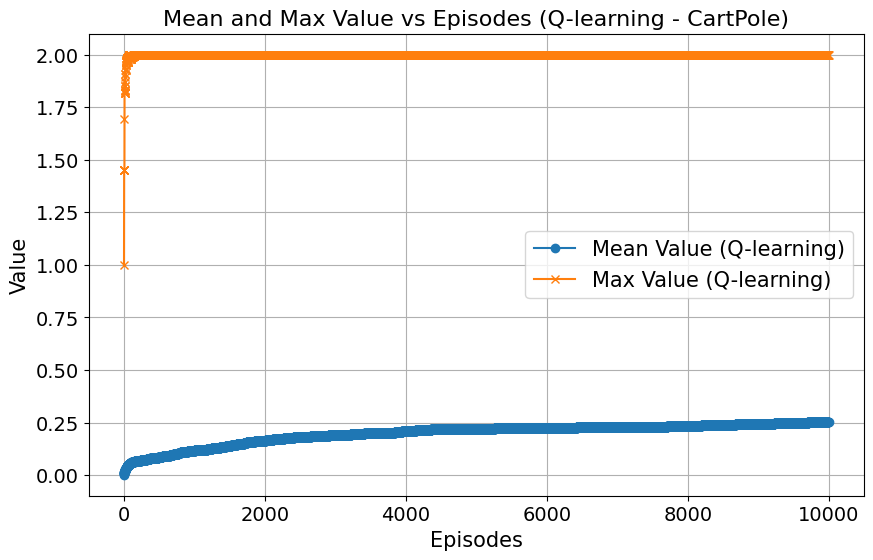

In [ ]:
# Assume Q_track is a numpy array of shape (n_episodes, n_states, n_actions)
# Replace this with your actual Q_track data from Q-learning
# Aggregate Q-values over actions to derive value function at each iteration
V_track_Q = np.max(Q_track, axis=2)  # Take the max Q-value across actions for each state

# Clip trailing zeros if convergence is reached before max iterations
mean_values_per_iter_Q = np.trim_zeros(np.mean(V_track_Q, axis=1), 'b')
max_values_per_iter_Q = np.trim_zeros(np.max(V_track_Q, axis=1), 'b')

# Plot mean and max values over episodes for Q-learning
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter_Q, label="Mean Value (Q-learning)", linestyle='-', marker='o')
plt.plot(max_values_per_iter_Q, label="Max Value (Q-learning)", linestyle='-', marker='x')

# Customize tick parameters for the x and y axes
plt.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis numbers
plt.tick_params(axis='y', labelsize=14)  # Increase font size for y-axis numbers

# Add labels, legend, and title
plt.xlabel("Episodes", fontsize=15)  # Add larger font for x-axis
plt.ylabel("Value", fontsize=15)  # Add larger font for y-axis
plt.title("Mean and Max Value vs Episodes (Q-learning - CartPole)", fontsize=16)  # Updated title
plt.legend(fontsize=15)  # Increased legend font size
plt.grid()

# Show plot
plt.show()

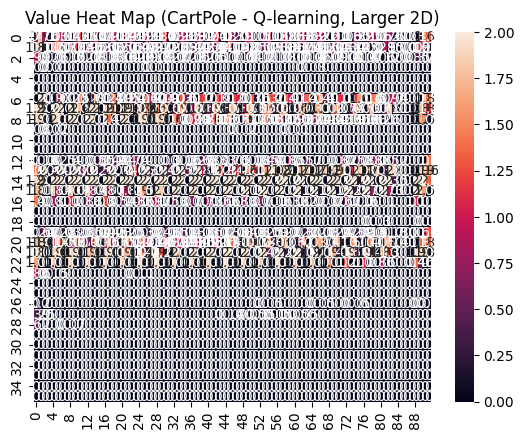

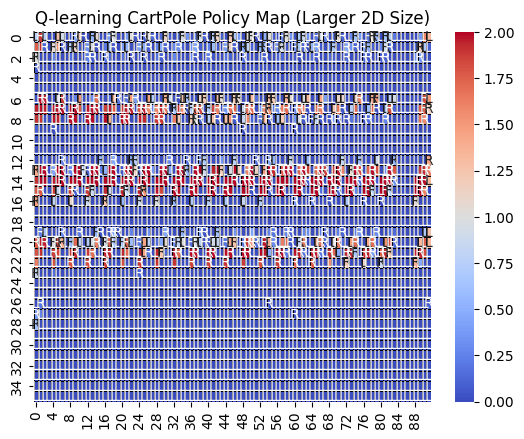

In [57]:
# Create actions dictionary for CartPole
cartpole_actions = {0: "L", 1: "R"}  # Left (L) and Right (R) actions

# Reshape the value function from Q-learning into a larger 2D array for visualization
reshaped_size = (6 * 6, 4 * 23)  # Combine position × velocity into one axis and angular velocity × angle into the other
V_Q_reshaped = np.around(V_Q.reshape(reshaped_size), 2)

# Reshape the policy from Q-learning into a larger 2D array
policy_array_Q = np.array([pi_Q[s] for s in range(len(pi_Q))])  # Convert policy dictionary to array
policy_reshaped_Q = policy_array_Q.reshape(reshaped_size)

# Map the policy actions to readable labels ("L" for Left, "R" for Right)
policy_map_Q = np.vectorize(cartpole_actions.get)(policy_reshaped_Q)

# Define the heatmap plotting function
@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.5,
        linecolor="black",
    ).set(title=title)
    plt.show()

# Title for the policy map
title_Q = "Q-learning CartPole Policy Map (Larger 2D Size)"

# Create the heatmap for the value function
Plots.values_heat_map(data=V_Q_reshaped, title="Value Heat Map (CartPole - Q-learning, Larger 2D)", size=reshaped_size)

# Create the heatmap for the policy map
Plots.modified_plot_policy(val_max=V_Q_reshaped, directions=policy_map_Q, map_size=reshaped_size, title=title_Q)

# SARSA

In [ ]:
# Set random seed
RANDOM_SEED = 10

# Define parameters for SARSA
gammas = [0.3, 0.5, 0.7, 0.9]
epsilon_decay = [0.3, 0.5, 0.7, 0.9]
n_iters = [10000]

# Initialize CartPole environment
base_env = gym.make('CartPole-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)

# Wrap the CartPole environment with custom parameters
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)

# Run SARSA grid search
rewards_and_params_results_sarsa, highest_avg_reward_sarsa, best_params_sarsa = GridSearch.sarsa_grid_search(
    env=cartpole,
    gamma=gammas,
    epsilon_decay=epsilon_decay,
    iters=n_iters,
    verbose=False
)

# Print the results
print("Highest Average Reward from SARSA:", highest_avg_reward_sarsa)
print("Best Parameters for SARSA:", best_params_sarsa)

# Highest Average Reward from SARSA: 141.42
# Best Parameters for SARSA: (0.9, 0.3, 10000)

 84%|████████▎ | 8356/10000 [01:40<00:41, 39.21it/s] c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\bettermdptools\algorithms\rl.py:296: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn("Episode was truncated.  TD target value may be incorrect.")


Highest Average Reward from SARSA: 141.42
Best Parameters for SARSA: (0.9, 0.3, 10000)


In [50]:
# Convert to a pandas DataFrame
df_sarsa = pd.DataFrame(rewards_and_params_results_sarsa)
df_sarsa[['gamma', 'epsilon_decay', 'iters']] = pd.DataFrame(df_sarsa['params'].tolist(), index=df_sarsa.index)
df_sarsa.drop(columns=['params'], inplace=True)

# Sort the DataFrame by avg_reward in descending order
df_sarsa = df_sarsa.sort_values(by='avg_reward', ascending=False)

# Save to CSV
csv_filename = "sarsa_cp_results.csv"
df_sarsa.to_csv(csv_filename, index=False)

print(f"Data has been saved to {csv_filename}")

Data has been saved to sarsa_cp_results.csv


In [51]:
print(df_sarsa)

    avg_reward  gamma  epsilon_decay  iters
12      141.42    0.9            0.3  10000
15      132.52    0.9            0.9  10000
13      118.06    0.9            0.5  10000
11      113.77    0.7            0.9  10000
14      105.88    0.9            0.7  10000
8       104.52    0.7            0.3  10000
4        95.81    0.5            0.3  10000
9        94.36    0.7            0.5  10000
6        91.74    0.5            0.7  10000
10       88.19    0.7            0.7  10000
5        79.48    0.5            0.5  10000
7        75.61    0.5            0.9  10000
1        66.48    0.3            0.5  10000
2        63.02    0.3            0.7  10000
0        62.26    0.3            0.3  10000
3        18.22    0.3            0.9  10000


In [53]:
# Set random seed
RANDOM_SEED = 10

# Initialize CartPole environment
base_env = gym.make('CartPole-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)

# Wrap the CartPole environment with custom parameters
cartpole = CartpoleWrapper(
    base_env,
    position_bins=6,  # Reduced bins
    velocity_bins=6,  # Reduced bins
    angular_velocity_bins=4,  # Reduced bins
    angular_center_resolution=0.1,  # Default value
    angular_outer_resolution=0.5   # Default value
)
cartpole.reset(seed=RANDOM_SEED)

# Define parameters for SARSA
gamma = 0.9
epsilon_decay = 0.3
n_iters = 10000

# Run SARSA
Q_SARSA, V_SARSA, pi_SARSA, Q_track_SARSA, pi_track_SARSA = RL(cartpole).sarsa(
    gamma=gamma,
    epsilon_decay_ratio=epsilon_decay,
    n_episodes=n_iters
)

 16%|█▌        | 1608/10000 [00:16<06:06, 22.91it/s]c:\Users\adria\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\bettermdptools\algorithms\rl.py:296: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn("Episode was truncated.  TD target value may be incorrect.")


In [54]:
# Test SARSA on CartPole
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
cartpole.action_space.seed(RANDOM_SEED)
cartpole.reset(seed=RANDOM_SEED)

# Run tests
test_scores_sarsa = TestEnv.test_env(env=cartpole, n_iters=1000, render=False, pi=pi_SARSA, user_input=False)

# Print results
print(f"Average Test Score (SARSA, CartPole): {np.mean(test_scores_sarsa)}")

Average Test Score (SARSA, CartPole): 111.044


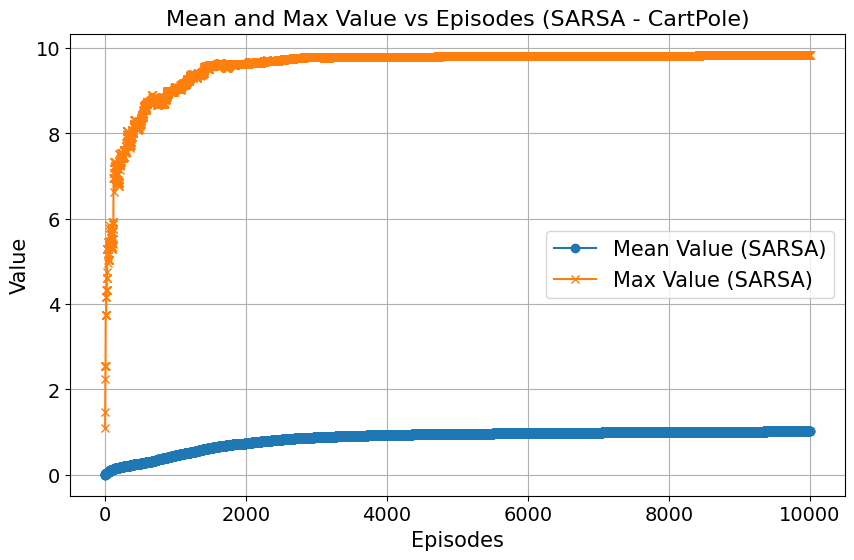

In [56]:
# Assume Q_track_SARSA is a numpy array of shape (n_episodes, n_states, n_actions)
# Replace this with your actual Q_track_SARSA data from SARSA
# Aggregate Q-values over actions to derive value function at each iteration
V_track_SARSA = np.max(Q_track_SARSA, axis=2)  # Take the max Q-value across actions for each state

# Clip trailing zeros if convergence is reached before max iterations
mean_values_per_iter_SARSA = np.trim_zeros(np.mean(V_track_SARSA, axis=1), 'b')
max_values_per_iter_SARSA = np.trim_zeros(np.max(V_track_SARSA, axis=1), 'b')

# Plot mean and max values over episodes for SARSA
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter_SARSA, label="Mean Value (SARSA)", linestyle='-', marker='o')
plt.plot(max_values_per_iter_SARSA, label="Max Value (SARSA)", linestyle='-', marker='x')

# Customize tick parameters for the x and y axes
plt.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis numbers
plt.tick_params(axis='y', labelsize=14)  # Increase font size for y-axis numbers

# Add labels, legend, and title
plt.xlabel("Episodes", fontsize=15)  # Add larger font for x-axis
plt.ylabel("Value", fontsize=15)  # Add larger font for y-axis
plt.title("Mean and Max Value vs Episodes (SARSA - CartPole)", fontsize=16)  # Updated title
plt.legend(fontsize=15)  # Increased legend font size
plt.grid()

# Show plot
plt.show()

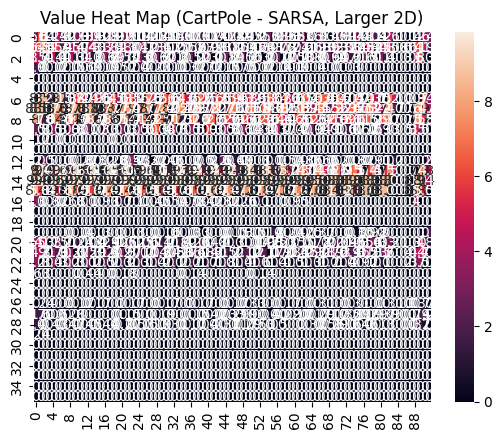

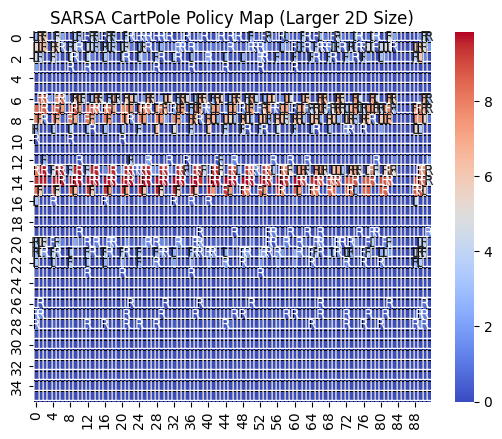

In [58]:
# Create actions dictionary for CartPole
cartpole_actions = {0: "L", 1: "R"}  # Left (L) and Right (R) actions

# Reshape the value function from SARSA into a larger 2D array for visualization
reshaped_size = (6 * 6, 4 * 23)  # Combine position × velocity into one axis and angular velocity × angle into the other
V_SARSA_reshaped = np.around(V_SARSA.reshape(reshaped_size), 2)

# Reshape the policy from SARSA into a larger 2D array
policy_array_SARSA = np.array([pi_SARSA[s] for s in range(len(pi_SARSA))])  # Convert policy dictionary to array
policy_reshaped_SARSA = policy_array_SARSA.reshape(reshaped_size)

# Map the policy actions to readable labels ("L" for Left, "R" for Right)
policy_map_SARSA = np.vectorize(cartpole_actions.get)(policy_reshaped_SARSA)

# Define the heatmap plotting function
@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.5,
        linecolor="black",
    ).set(title=title)
    plt.show()

# Title for the policy map
title_SARSA = "SARSA CartPole Policy Map (Larger 2D Size)"

# Create the heatmap for the value function
Plots.values_heat_map(data=V_SARSA_reshaped, title="Value Heat Map (CartPole - SARSA, Larger 2D)", size=reshaped_size)

# Create the heatmap for the policy map
Plots.modified_plot_policy(val_max=V_SARSA_reshaped, directions=policy_map_SARSA, map_size=reshaped_size, title=title_SARSA)

In [ ]:
# result 
# Average Test Score (Value Iteration, CartPole): 9.367
# Average Test Score (Policy Iteration, CartPole): 9.367
# Average Test Score (SARSA, CartPole): 111.044
# Average Test Score (Q-learning, CartPole): 119.034